## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import joypy
import seaborn as sns

from itertools import product
from scipy.cluster import hierarchy

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx
import community
%matplotlib inline

In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rank import rank
from processify import processify
from egad import run_egad
from egad_by_gene import run_egad_gene_score
import egad_train_test_terms as egad_tt
import biccn_nw_perf_funcs as perf
import load_pearson_networks
import differential_coexpression as dce

## Functions

In [6]:
def compute_dce(subclass1, subclass2, alpha=.05, two_sided=False):
    agg_diff = np.zeros([genes.shape[0], genes.shape[0]])
    nws_path = '/home/bharris/biccn_paper/data/networks/'
    n_datasets = 0
    for dataset in all_datasets:
        try:
            logging.info(dataset)
            nw1 = pd.read_hdf(
                f'{nws_path}{dataset}/coexpression_nw_subclass_label_{subclass1}.hdf5',
                'nw')
            nw2 = pd.read_hdf(
                f'{nws_path}{dataset}/coexpression_nw_subclass_label_{subclass2}.hdf5',
                'nw')
            agg_diff += rank(nw1.values - nw2.values)
            n_datasets += 1
        except:
            pass
        try:
            del nw1
        except:
            pass
        try:
            del nw2
        except:
            pass
        gc.collect()
    null = dce.build_null(n_datasets, genes.shape[0])
    nw_fdr, fdr_values, densities = dce.calculate_quantile_fdr(
        agg_diff, null, center=two_sided)
    del agg_diff, null
    gc.collect()
    summary_stats = pd.DataFrame(np.stack((fdr_values, densities)).T,
                                 columns=['FDR', 'Density'])
    return pd.DataFrame(nw_fdr, index=genes, columns=genes), summary_stats

In [7]:
def get_intervals(summary, fdr_values = [.1, .01, .001]):
    df1 = pd.Series(
        {val: summary[summary.FDR < val].Density.max()
         for val in fdr_values},
        name='Density')
    df1.index.name='FDR'
    df1 = df1.reset_index()
    #df1.at[3] = summary.sort_values('FDR').iloc[0]
    return df1.sort_values('FDR')

In [140]:
def combine_perf(dce, multi, level):
    cl = pd.concat([dce, multi], axis=1)
    cl.columns = ['Differential Co-expression', 'Multiscale']
    cl['level'] = level
    cl.dropna(inplace=True)
    return cl


## Load Data

In [8]:
marker_lists = pd.read_csv('/home/bharris/biccn_paper/data/stephan_marker_nw.csv',index_col=0)
replace_space = np.vectorize(lambda x: x.replace(' ', '_'))
replace_slash = np.vectorize(lambda x: x.replace('/', '_'))
replace_dot = np.vectorize(lambda x: x.replace('.', '_'))

marker_lists.columns = replace_dot(replace_slash(replace_space(marker_lists.columns)))

subclass_colors = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_colors.csv',
    index_col=1,
    header=None)[0]

subclass_colors.index = replace_slash(replace_space(subclass_colors.index))

subclass_colors = subclass_colors[marker_lists.columns].dropna()
subclass_colors.drop('L5_ET',inplace=True)
marker_lists = marker_lists[subclass_colors.index]

all_subclasses = subclass_colors.index

In [9]:
cluster_info = pd.read_csv('/home/bharris/biccn_paper/data/integrated_cluster.annotation.csv',index_col='cluster_label')
cluster_info.head()

,cluster_id,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,cl,cluster_size,size
cluster_label,,,,,,,,,,,
Lamp5 Pax6,1,#DDACC9,1,Lamp5,#DA808C,1,GABAergic,#F05A28,1,700,700
Lamp5 Egln3_1,2,#FF88AD,1,Lamp5,#DA808C,1,GABAergic,#F05A28,2,618,618
Lamp5 Egln3_2,3,#DD8091,1,Lamp5,#DA808C,1,GABAergic,#F05A28,3,814,814
Lamp5 Egln3_3,4,#F08E98,1,Lamp5,#DA808C,1,GABAergic,#F05A28,4,1276,1276
Lamp5 Pdlim5_1,5,#FF7290,1,Lamp5,#DA808C,1,GABAergic,#F05A28,5,1288,1288


In [10]:
cluster_subclass = pd.get_dummies(cluster_info.subclass_label)
cluster_subclass.columns = replace_slash(replace_space(cluster_subclass.columns))
cluster_subclass = cluster_subclass[all_subclasses]
cluster_subclass = cluster_subclass[cluster_subclass.sum(axis=1)>0]
cluster_subclass.index = replace_slash(replace_space(cluster_subclass.index))
cluster_subclass


,L5_IT,L6_IT_Car3,Vip,L5_6_NP,L6_IT,L2_3_IT,L6b,L6_CT,Sncg,Sst,Lamp5,Pvalb
Lamp5_Pax6,0,0,0,0,0,0,0,0,0,0,1,0
Lamp5_Egln3_1,0,0,0,0,0,0,0,0,0,0,1,0
Lamp5_Egln3_2,0,0,0,0,0,0,0,0,0,0,1,0
Lamp5_Egln3_3,0,0,0,0,0,0,0,0,0,0,1,0
Lamp5_Pdlim5_1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
L6b_Col6a1,0,0,0,0,0,0,1,0,0,0,0,0
L6b_Shisa6_1,0,0,0,0,0,0,1,0,0,0,0,0
L6b_Shisa6_2,0,0,0,0,0,0,1,0,0,0,0,0
L6b_Ror1,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
dataset_dict = perf.dataset_dict
genes = perf.genes
all_datasets = np.array(list(dataset_dict.keys()))

In [12]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_ann = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                     index_col='V1')

go_slim = np.genfromtxt('/home/bharris/GO_data/aug4.GOslim', dtype=str)
go_mouse_slim = go_mouse[np.intersect1d(go_mouse.columns, go_slim)]

In [13]:
kegg_tidy = pd.read_csv('/home/bharris/reference_networks/kegg/kegg_all.csv',
                        index_col=0)
kegg_tidy.set_index('V3', inplace=True)

kegg_genes = np.unique(kegg_tidy.index.values)

kegg_terms = np.unique(kegg_tidy.V1.values)

kegg = pd.DataFrame(0, index=kegg_genes, columns=kegg_terms)
for i, j in kegg_tidy[['V1']].groupby('V1').groups.items():
    kegg.at[j, i] = 1

In [14]:
pearson_nws = load_pearson_networks.load_all_networks()

2020-08-24 16:15:11,356 - zeng_10x_cell
2020-08-24 16:15:39,957 - zeng_10x_nuc
2020-08-24 16:16:05,033 - zeng_smart_cell
2020-08-24 16:16:30,243 - zeng_smart_nuc
2020-08-24 16:16:54,474 - zeng_10x_cell_v3
2020-08-24 16:17:19,127 - zeng_10x_nuc_v3
2020-08-24 16:17:44,851 - macosko_10x_nuc_v3


## GO and Kegg Compare to Multiscale (Supp Fig 7)

In [118]:
all_metadata_color = pd.read_csv(
    '/home/bharris/biccn_paper/data/biccn_mouse_full_labels_new.csv',
    index_col=0)
class_colors = all_metadata_color[['class_label', 'class_color']].groupby(
    ['class_label', 'class_color']).size().reset_index().sort_values(
        ['class_label', 0], ascending=False).drop_duplicates(
            subset='class_label').set_index('class_label')['class_color']
replace_hyphen = np.vectorize(lambda x: x.replace('-', '.'))
class_colors.index = replace_hyphen(class_colors.index)
class_colors = class_colors[['GABAergic', 'Glutamatergic']]

In [125]:
go_class_label_multi = run_egad(
    go_mouse_slim, pearson_nws['class_label']['aggregate'])[['AUC']]
go_subclass_label_multi = run_egad(
    go_mouse_slim, pearson_nws['subclass_label']['aggregate'])[['AUC']]
go_cluster_label_multi = run_egad(
    go_mouse_slim, pearson_nws['joint_cluster_label']['aggregate'])[['AUC']]

In [153]:
kegg_class_label_multi = run_egad(
    kegg, pearson_nws['class_label']['aggregate'])[['AUC']]
kegg_subclass_label_multi = run_egad(
    kegg, pearson_nws['subclass_label']['aggregate'])[['AUC']]
kegg_cluster_label_multi = run_egad(
    kegg, pearson_nws['joint_cluster_label']['aggregate'])[['AUC']]

In [142]:
cl_perf = combine_perf(go_class_label.loc['GABAergic'].T['class_label'],
                       go_class_label_multi.AUC, 'Class Label')
scl_perf = combine_perf(go_class_label.loc['GABAergic'].T['subclass_label'],
                        go_subclass_label_multi.AUC, 'Subclass Label')
cll_perf = combine_perf(go_class_label.loc['GABAergic'].T['cluster_label'],
                        go_cluster_label_multi.AUC, 'Cluster Label')
combined_perf = pd.concat([cl_perf, scl_perf, cll_perf])

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [154]:
cl_perf_kegg = combine_perf(kegg_class_label.loc['GABAergic'].T['class_label'],
                            kegg_class_label_multi.AUC, 'Class Label')
scl_perf_kegg = combine_perf(
    kegg_class_label.loc['GABAergic'].T['subclass_label'],
    kegg_subclass_label_multi.AUC, 'Subclass Label')
cll_perf_kegg = combine_perf(
    kegg_class_label.loc['GABAergic'].T['cluster_label'],
    kegg_cluster_label_multi.AUC, 'Cluster Label')
combined_perf_kegg = pd.concat([cl_perf_kegg, scl_perf_kegg, cll_perf_kegg])

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


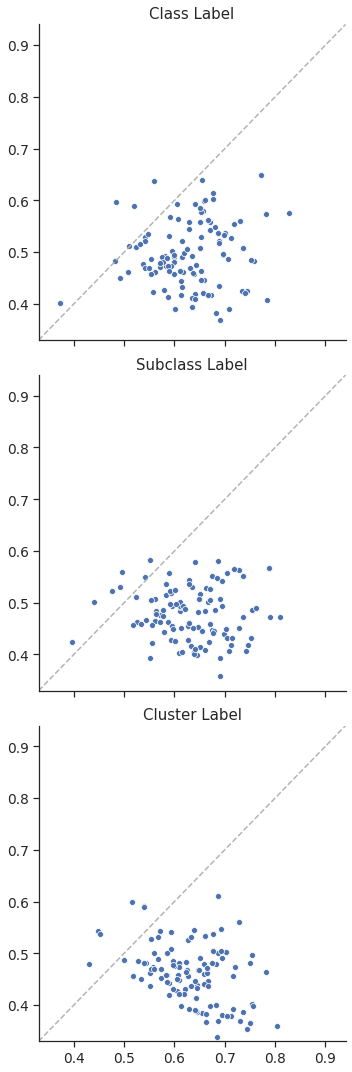

In [159]:
g = sns.relplot(data=combined_perf,
                x='Multiscale',
                y='Differential Co-expression',
                row='level',
                row_order=['Class Label', 'Subclass Label', 'Cluster Label'],
                kind='scatter')

g.set(xlim=[.33, .94], ylim=[.33, .94])


def const_line(*args, **kwargs):
    plt.plot([.33, .94], [.33, .94], C='.7', ls='--')


g.map(const_line)
g.set_titles('{row_name}')
plt.savefig('/home/bharris/biccn_paper/figures/dce_vs_multiscale_GO.pdf',
            transparent=True)

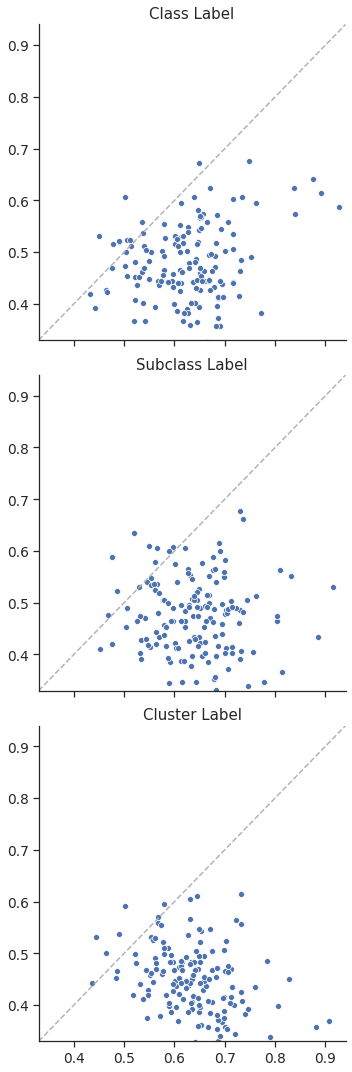

In [158]:
g = sns.relplot(data=combined_perf_kegg,
                x='Multiscale',
                y='Differential Co-expression',
                row='level',
                row_order=['Class Label', 'Subclass Label', 'Cluster Label'],
                kind='scatter')

g.set(xlim=[.33, .94], ylim=[.33, .94])


def const_line(*args, **kwargs):
    plt.plot([.33, .94], [.33, .94], C='.7', ls='--')


g.map(const_line)
g.set_titles('{row_name}')
plt.savefig('/home/bharris/biccn_paper/figures/dce_vs_multiscale_KEGG.pdf',
            transparent=True)

## Compare to Multiscale Model

In [29]:
multiscale_performance_subclass = run_egad(
    marker_lists, pearson_nws['subclass_label']['aggregate']).AUC
multiscale_performance_subclass.name = 'Multiscale Performance'

In [32]:
dce_1va_diag = pd.Series(np.diagonal(dce_cluster_res_1va.values),
                         index=dce_cluster_res_1va.index,
                         name='Differential Co-expression')
multiscale_vs_dce_subclass = pd.concat([multiscale_performance_subclass, dce_1va_diag],
                                       axis=1).reset_index()
multiscale_vs_dce_subclass['level'] = 'Subclass Label'

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [33]:
multiscale_performance_cluster = run_egad(
    marker_lists, pearson_nws['joint_cluster_label']['aggregate']).AUC
multiscale_performance_cluster.name = 'Multiscale Performance'

In [39]:
temp = dce_cluster_res_1va_by_cluster.T.values.copy().astype(float)
diagonal = np.diag(temp).copy()
dce_1va_by_clust_diag = pd.Series(diagonal,
                                  index=dce_cluster_res_1va_by_cluster.index,
                                  name='Differential Co-expression')
multiscale_vs_dce_cluster = pd.concat(
    [multiscale_performance_cluster, dce_1va_by_clust_diag], axis=1).reset_index()
multiscale_vs_dce_cluster['level'] = 'Cluster Label'

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [40]:
compare_dce_multiscale = pd.concat(
    [multiscale_vs_dce_cluster, multiscale_vs_dce_subclass])
compare_dce_multiscale.rename(columns={'index': 'subclass'}, inplace=True)

In [41]:
compare_dce_multiscale.groupby('level').mean()

,Multiscale Performance,Differential Co-expression
level,,
Cluster Label,0.851041,0.514650
Subclass Label,0.866150,0.694916


In [42]:
compare_dce_multiscale.groupby('level').apply(
    lambda x: stats.ttest_rel(x['Multiscale Performance'].values, x[
        'Differential Co-expression'].values))

level
Cluster Label      (21.820330203269247, 2.095106919271242e-10)
Subclass Label    (11.656630054292696, 1.5668750523520595e-07)
dtype: object

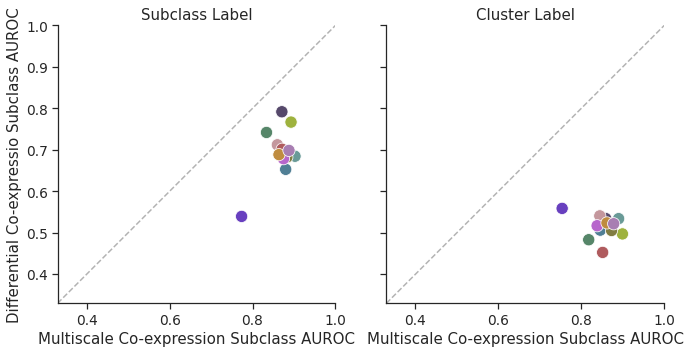

In [44]:
g = sns.relplot(data=compare_dce_multiscale,
                x='Multiscale Performance',
                y='Differential Co-expression',
                col='level',
                col_order=['Subclass Label', 'Cluster Label'],
                hue='subclass',
                hue_order=subclass_colors.index,
                palette=sns.color_palette(subclass_colors.values, desat=.5),
                s=150,
                legend=False)
g.set(aspect='equal', xlim=[.33, 1], ylim=[.33, 1])


def const_line(*args, **kwargs):
    plt.plot([.33, 1], [.33, 1], C='.7', ls='--')


g.map(const_line)
#g.set_xlabels('Multiscale Co-expression Subclass AUROC')
#g.set_ylabels('Differential Co-expressio Subclass AUROC')
g.set_axis_labels(x_var='Multiscale Co-expression Subclass AUROC',
                  y_var='Differential Co-expressio Subclass AUROC')
g.set_titles('{col_name}')
plt.tight_layout()
# plt.savefig('/home/bharris/biccn_paper/figures/dce_vs_multiscale.pdf',
#             transparent=True)

## Dataset num Analysis

In [45]:
dataset_num = pd.read_csv(
    '/home/bharris/biccn_paper/data/differential_coexpression/class_differential_coexpression.csv'
)

dataset_num.drop('Unnamed: 0', inplace=True, axis=1)

dataset_num = dataset_num[dataset_num.cell_type == 'GABAergic']

In [46]:
ds_num = dataset_num.groupby(['n_datasets', 'FDR',
                              'level']).mean().reset_index()

ds_num.n_datasets = ds_num.n_datasets.astype(int)


In [47]:
level_dict = {
    'class_label': 'Class Label',
    'subclass_label': 'Subclass Label',
    'joint_cluster_label': 'Cluster Label'
}

In [48]:
cleaned_results=[]
for level in ['class_label','subclass_label','joint_cluster_label']:
    for i in np.arange(2,8):
        temp = ds_num[(ds_num.n_datasets == i)
                  & (ds_num.level == level)].sort_values('FDR')
        temp.Density = np.minimum.accumulate(temp.Density.values[::-1])[::-1]
        temp.drop_duplicates('Density',keep='first',inplace=True)
        temp['level'] = level_dict[level]
        temp['# of Datasets'] = i
        cleaned_results.append(temp)

cleaned_n_ds_res = pd.concat(cleaned_results)

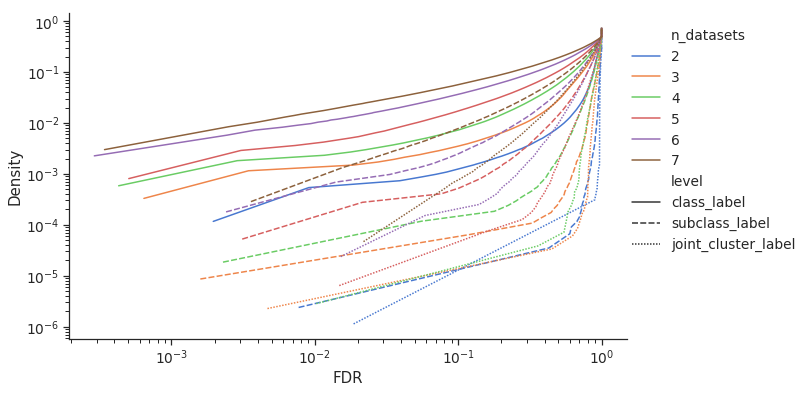

In [332]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=cleaned_n_ds_res,
             x='FDR',
             y='Density',
             hue='n_datasets',
             style='level',
             sort=False,
             estimator=None,
             hue_order=np.arange(2,8),
             palette=sns.color_palette(
                 'muted',
                 n_colors=cleaned_n_ds_res.n_datasets.unique().shape[0]),
             ax=ax)
ax.set(xscale='log', yscale='log')
ax.legend(loc=(1, .25), frameon=False)
plt.show()

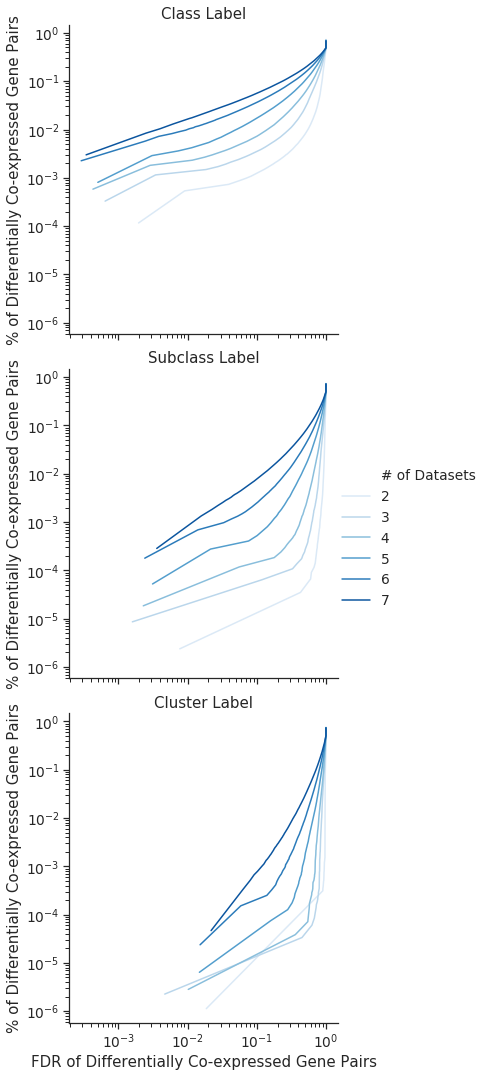

In [426]:
g = sns.relplot(data=cleaned_n_ds_res,
                x='FDR',
                y='Density',
                hue='# of Datasets',
                row='level',
                row_order=['Class Label', 'Subclass Label', 'Cluster Label'],
                sort=False,
                estimator=None,
                hue_order=np.arange(2, 8),
                kind='line',
                palette=sns.color_palette(
                    'Blues',
                    n_colors=cleaned_n_ds_res.n_datasets.unique().shape[0]))
g.set(xscale='log', yscale='log')
g.set_titles('{row_name}')
g.set_axis_labels(x_var='FDR of Differentially Co-expressed Gene Pairs',
                  y_var='% of Differentially Co-expressed Gene Pairs')
plt.savefig('/home/bharris/biccn_paper/figures/dce_n_datasets.pdf',
            transparent=True)

## Figure 4

In [117]:
## Load differential co-expression results
dce_path = '/home/bharris/biccn_paper/data/differential_coexpression/'
class_combos = list(product(['GABAergic', 'Glutamatergic'],
                       ['class_label', 'subclass_label', 'cluster_label']))
class_dce_summary = []
for class_label, level in class_combos:
    df = pd.read_hdf(f'{dce_path}class_dce_{class_label}_{level}.hdf5',
                     'summary')
    df['class_label'] = class_label
    df['level'] = level
    class_dce_summary.append(df)
    del df
    gc.collect()
class_dce_summary = pd.concat(class_dce_summary)

In [ ]:
g = sns.relplot(data=compare_dce_multiscale,
                x='Multiscale Performance',
                y='Differential Co-expression',
                col='level',
                col_order=['Subclass Label', 'Cluster Label'],
                hue='subclass',
                hue_order=subclass_colors.index,
                palette=sns.color_palette(subclass_colors.values, desat=.5),
                s=150,
                legend=False)
g.set(aspect='equal', xlim=[.33, 1], ylim=[.33, 1])


def const_line(*args, **kwargs):
    plt.plot([.33, 1], [.33, 1], C='.7', ls='--')


g.map(const_line)
#g.set_xlabels('Multiscale Co-expression Subclass AUROC')
#g.set_ylabels('Differential Co-expressio Subclass AUROC')
g.set_axis_labels(x_var='Multiscale Co-expression Subclass AUROC',
                  y_var='Differential Co-expressio Subclass AUROC')
g.set_titles('{col_name}')
plt.tight_layout()
# plt.savefig('/home/bharris/biccn_paper/figures/dce_vs_multiscale.pdf',
#             transparent=True)

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


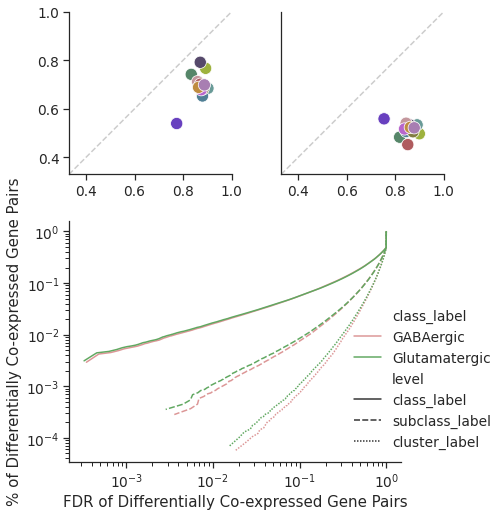

In [116]:
grid_shape = (12, 12)
fig = plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid(grid_shape, (0, 0), rowspan=6, colspan=4)
ax2 = plt.subplot2grid(grid_shape, (0, 5), rowspan=6, colspan=4)
ax3 = plt.subplot2grid(grid_shape, (6, 0), rowspan=6, colspan=8)
#ax4 = plt.subplot2grid(grid_shape, (0, 11), rowspan=4, colspan=7)
#ax5 = plt.subplot2grid(grid_shape, (4, 11), rowspan=4, colspan=7)
#ax6 = plt.subplot2grid(grid_shape, (8, 11), rowspan=4, colspan=7)

sns.scatterplot(data=compare_dce_multiscale[compare_dce_multiscale.level ==
                                            'Subclass Label'],
                x='Multiscale Performance',
                y='Differential Co-expression',
                s=150,
                hue='subclass',
                hue_order=subclass_colors.index,
                palette=sns.color_palette(subclass_colors.values, desat=.5),
                legend=False,
                ax=ax1)
ax1.set(aspect='equal', xlim=[.33, 1], ylim=[.33, 1])
sns.scatterplot(data=compare_dce_multiscale[compare_dce_multiscale.level ==
                                            'Cluster Label'],
                x='Multiscale Performance',
                y='Differential Co-expression',
                s=150,
                hue='subclass',
                hue_order=subclass_colors.index,
                palette=sns.color_palette(subclass_colors.values, desat=.5),
                legend=False,
                ax=ax2)
ax2.set(aspect='equal', xlim=[.33, 1], ylim=[.33, 1])

sns.lineplot(data=class_dce_summary,
             x='FDR',
             y='Density',
             hue='class_label',
             hue_order=class_colors.index,
             palette=sns.color_palette(class_colors.values, desat=.5),
             style='level',
             estimator=None,
             sort=False,
             ax=ax3)
ax3.set(xscale='log',
        yscale='log',
        xlabel='FDR of Differentially Co-expressed Gene Pairs',
        ylabel='% of Differentially Co-expressed Gene Pairs')
ax3.legend(loc=(.84, .03), frameon=False, title=None, ncol=1)

ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')
ax1.set_xticks([.4, .6, .8, 1.0])
ax2.set_xticks([.4, .6, .8, 1.0])
ax2.set_yticks([])
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), ls='--', c='.8')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), ls='--', c='.8')

plt.tight_layout()
plt.savefig(
    '/home/bharris/biccn_paper/figures/figure4_differential_coexpression_A_B.pdf',
    transparent=True)

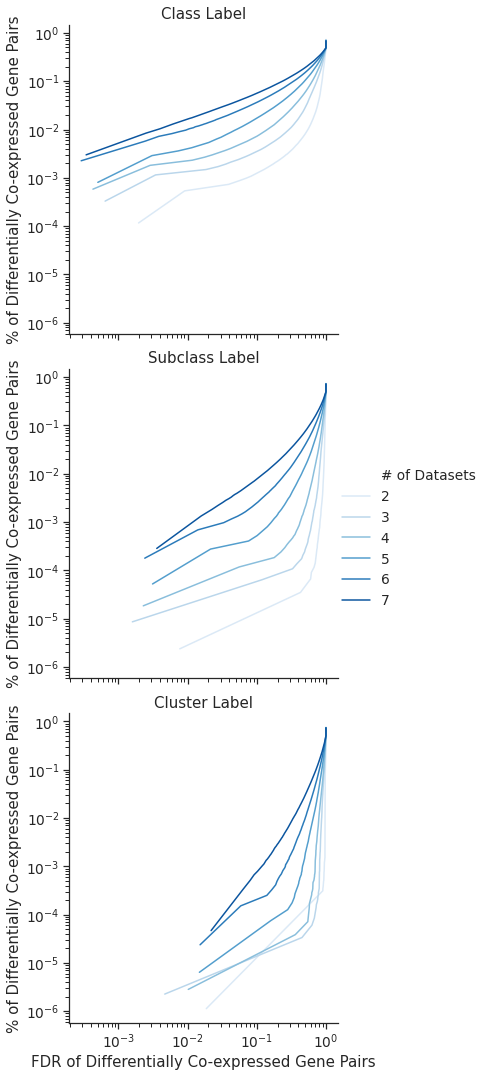

In [87]:
g = sns.relplot(data=cleaned_n_ds_res,
                x='FDR',
                y='Density',
                hue='# of Datasets',
                row='level',
                row_order=['Class Label', 'Subclass Label', 'Cluster Label'],
                sort=False,
                estimator=None,
                hue_order=np.arange(2, 8),
                kind='line',
                palette=sns.color_palette(
                    'Blues',
                    n_colors=cleaned_n_ds_res.n_datasets.unique().shape[0]))
g.set(xscale='log', yscale='log')
g.set_titles('{row_name}')
g.set_axis_labels(x_var='FDR of Differentially Co-expressed Gene Pairs',
                  y_var='% of Differentially Co-expressed Gene Pairs')
# plt.savefig('/home/bharris/biccn_paper/figures/dce_n_datasets.pdf',
#             transparent=True)